In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

from ipynb.fs.full.SeedFinder import all_seeds

In [3]:
def display_seed(seed):
    plt.imshow(seed, cmap='gray')
    plt.title(f'seed')
    plt.colorbar()
    plt.show()

In [4]:
def find_seed_contour(seed, threshold=400):
    normalized_image = cv2.normalize(seed.copy(), None, 0, 255, cv2.NORM_MINMAX)
    image_uint8 = normalized_image.astype(np.uint8)

    _, binary_image = cv2.threshold(image_uint8, int(threshold * 255 / 4096), 255, cv2.THRESH_BINARY)

    contours, hierarchy = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return max(contours, key=cv2.contourArea)

In [5]:
def extract_width_height_from_contour(contour):
    rightmost_point = max(contour, key=lambda point: point[0][0])  # Max x-coordinate
    leftmost_point = min(contour, key=lambda point: point[0][0])  # Min x-coordinate
    uppermost_point = min(contour, key=lambda point: point[0][1])  # Min y-coordinate
    downmost_point = max(contour, key=lambda point: point[0][1])  # Max y-coordinate
    y_uppermost, x_leftmost = uppermost_point[0][1] - 1, leftmost_point[0][0] - 1
    y_downmost, x_rightmost = downmost_point[0][1] + 1, rightmost_point[0][0] + 1
    return x_rightmost - x_leftmost, y_downmost - y_uppermost, x_leftmost, y_uppermost

In [6]:
def find_seed_width_height_area(seed):
    seed_contour = find_seed_contour(seed)
    area = cv2.contourArea(seed_contour)
    return *extract_width_height_from_contour(seed_contour), area

In [7]:
from scipy.spatial import Delaunay

def find_seed_mask(seed):
    contour = find_seed_contour(seed)
    width, height, x_start, y_start, _ = find_seed_width_height_area(seed)
    points = contour.reshape(-1, 2)
    tri = Delaunay(points)
    mask = np.zeros(seed.shape, dtype=np.uint8)
    for simplex in tri.simplices:
        triangle = points[simplex]
        cv2.fillConvexPoly(mask, triangle, 255)
    cv2.drawContours(mask, contour, -1, (255), thickness=cv2.FILLED)
    mask = mask[y_start:y_start+height, x_start:x_start+width]
    return mask, y_start, x_start, height, width

In [8]:
def find_seed_masked_image(seed):
    mask, y_start, x_start, height, width = find_seed_mask(seed)
    masked_image = cv2.bitwise_and(seed[y_start:y_start+height, x_start:x_start+width], seed[y_start:y_start+height, x_start:x_start+width], mask=mask)
    return masked_image

In [9]:
def extract_seed_pixels(seed, start_band=100, end_band=740):
    seed_mask_200, y_start, x_start, height, width = find_seed_mask(seed[:,:,200])
    seed_mask_all_bands = seed[y_start:y_start+height,x_start:x_start+width,start_band:end_band]
    seed_pixels_200 = np.argwhere(seed_mask_200 & seed_mask_all_bands.all(axis=-1))
    return seed_mask_all_bands[seed_pixels_200[:, 0], seed_pixels_200[:, 1], :]

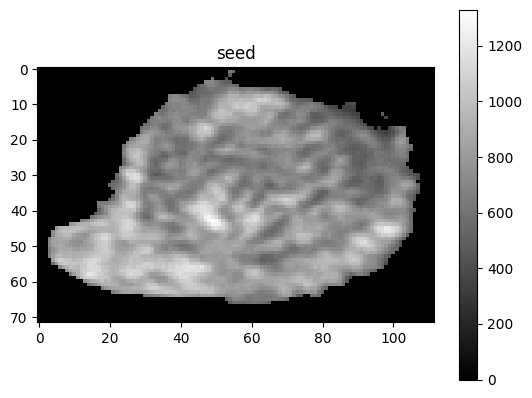

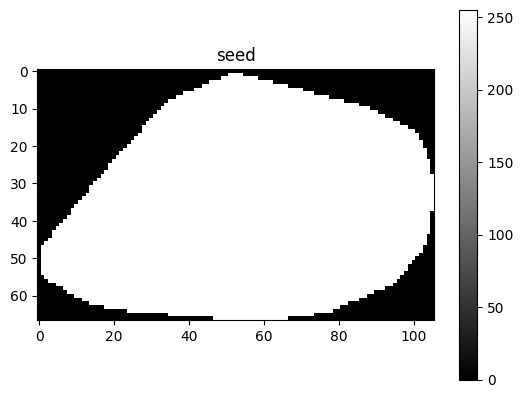

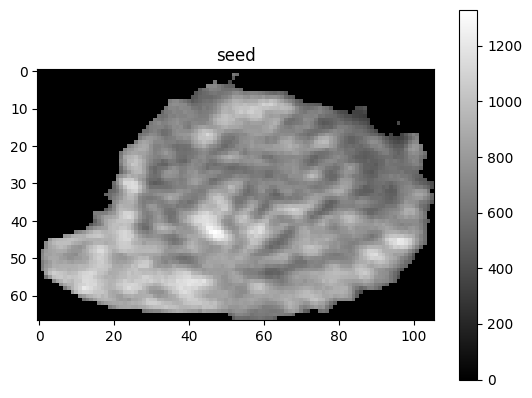

In [10]:
seed = np.load(all_seeds[0])[:,:,200]
mask, _, _, _, _ = find_seed_mask(seed)
masked_image = find_seed_masked_image(seed)

display_seed(seed)
display_seed(mask)
display_seed(masked_image)